# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
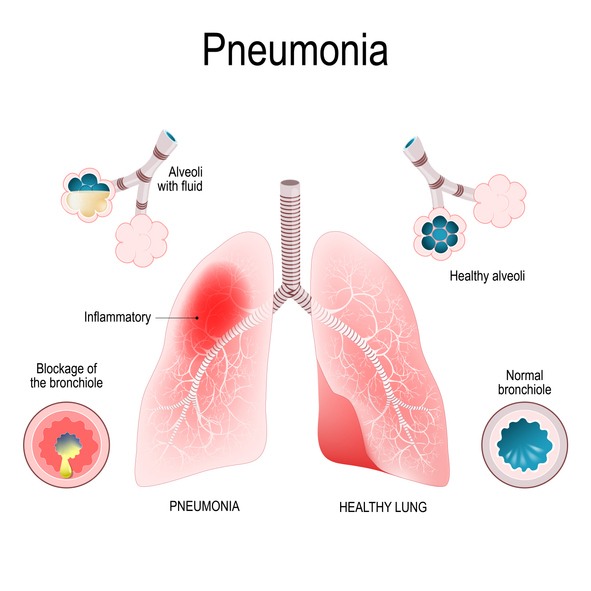

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Uncomment dit en run het voor data set
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Importing the necessary libraries

In [2]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow / Keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Loading the Dataset

In [4]:
# TODO: add your own paths here
import os

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'chest_xray/chest_xray')

train = get_training_data(os.path.join(DATA_DIR, 'train'))
test = get_training_data(os.path.join(DATA_DIR, 'test'))
val = get_training_data(os.path.join(DATA_DIR, 'val'))


# Data Visualization & Preprocessing

<Axes: ylabel='count'>

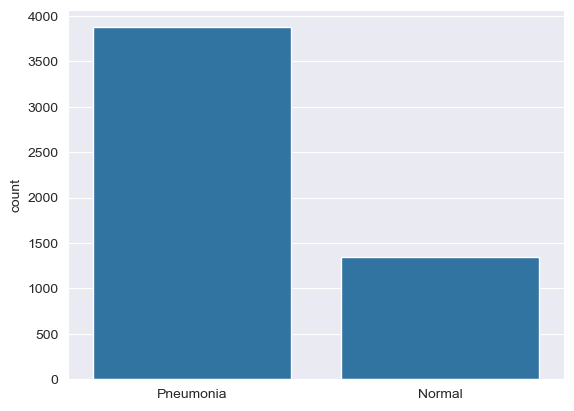

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

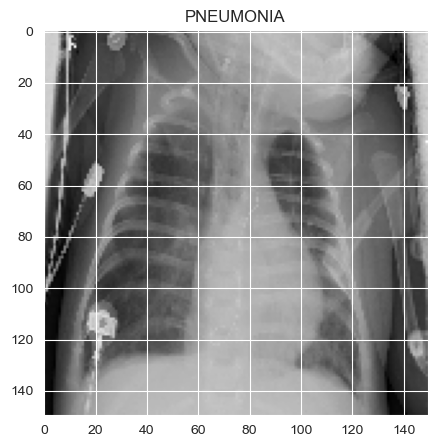

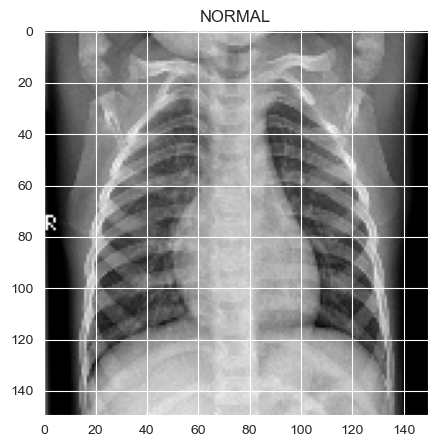

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
cnn_model = model

Epoch 1/12


/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 960ms/step - accuracy: 0.7964 - loss: 0.9392 - val_accuracy: 0.5000 - val_loss: 44.8795 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1844s 11s/step - accuracy: 0.8990 - loss: 0.2626 - val_accuracy: 0.5000 - val_loss: 40.9810 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.9119 - loss: 0.2264
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 959ms/step - accuracy: 0.9119 - loss: 0.2263 - val_accuracy: 0.5000 - val_loss: 42.7937 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 921ms/step - accuracy: 0.9483 - loss: 0.1550 - val_accuracy: 0.5625 - val_loss: 5.1502 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 902ms/step - accuracy: 0.9548 - loss: 0.1348 - val_accuracy: 0.5000 - val_loss: 35.0651 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0

In [52]:
preprocess_input = keras.applications.xception.preprocess_input
baseline_predictions = cnn_model.predict(x_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step


In [53]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = int(tf.argmax(preds[0]))
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [54]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
import matplotlib as mpl
def display_gradcam(img_array, heatmap, alpha=0.4, subplot=False):
    img = img_array[0]
    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    if not subplot:
        plt.title("Grad-CAM")
        plt.show()

Using layer: conv2d_4
test inputs: [<KerasTensor shape=(None, 150, 150, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_305>]
test outputs: [(None, 10, 10, 256), (None, 1)]
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step


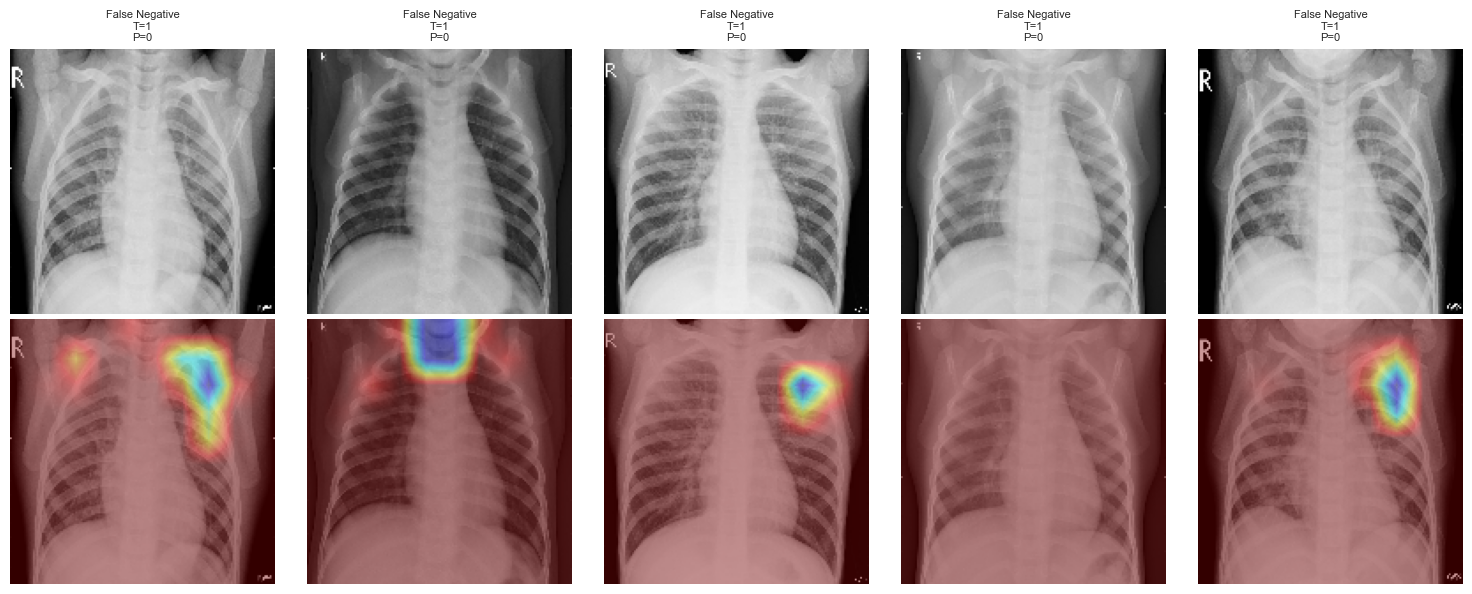

In [58]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D

baseline_model = cnn_model

last_layer = "conv2d_4"
print("Using layer:", last_layer)

input_tensor = Input(shape=(150, 150, 1))

x = input_tensor                      
for layer in baseline_model.layers:
    x = layer(x)
    if layer.name == last_layer:
        conv_output = x                

predictions = x                        
grad_model = Model(inputs=input_tensor,
                   outputs=[conv_output, predictions])

print("test inputs:", grad_model.inputs)
print("test outputs:", [o.shape for o in grad_model.outputs])

def make_gradcam_heatmap(img_tensor, grad_model, eps=1e-8):
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads        = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    cam          = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    cam          = tf.maximum(cam, 0) / (tf.reduce_max(cam) + eps)
    return cam.numpy()

def overlay_heatmap(gray, heatmap, alpha=0.4):
    rgb      = np.stack([gray]*3, axis=-1)
    rgb_uint = (rgb*255).astype('uint8')
    hm       = cv2.resize(heatmap, (gray.shape[1], gray.shape[0]))
    jet_map  = cv2.applyColorMap(np.uint8(255*hm), cv2.COLORMAP_JET)
    return cv2.addWeighted(rgb_uint, 1-alpha, jet_map, alpha, 0)

preds      = baseline_model.predict(x_test)
pred_lbls  = (preds.ravel()>0.5).astype(int)
false_pos  = np.where((pred_lbls==1)&(y_test==0))[0]
false_neg  = np.where((pred_lbls==0)&(y_test==1))[0]

plt.figure(figsize=(15,6))

def plot_group(indices, start_col, title):
    for i, idx in enumerate(indices[:5]):
        gray   = x_test[idx].reshape(150,150)
        batch  = np.expand_dims(gray, axis=(0, -1)) 
        heatmap= make_gradcam_heatmap(batch, grad_model)
        over   = overlay_heatmap(gray, heatmap)

        plt.subplot(2, 5, start_col + i)
        plt.imshow(gray, cmap='gray')
        plt.title(f"{title}\nT={y_test[idx]}\nP={pred_lbls[idx]}", fontsize=8)
        plt.axis('off')
        plt.subplot(2, 5, start_col + 5 + i)
        plt.imshow(over)
        plt.axis('off')

plot_group(false_pos, 1, "False Positive")
plot_group(false_neg, 1, "False Negative")

plt.tight_layout()
plt.show()

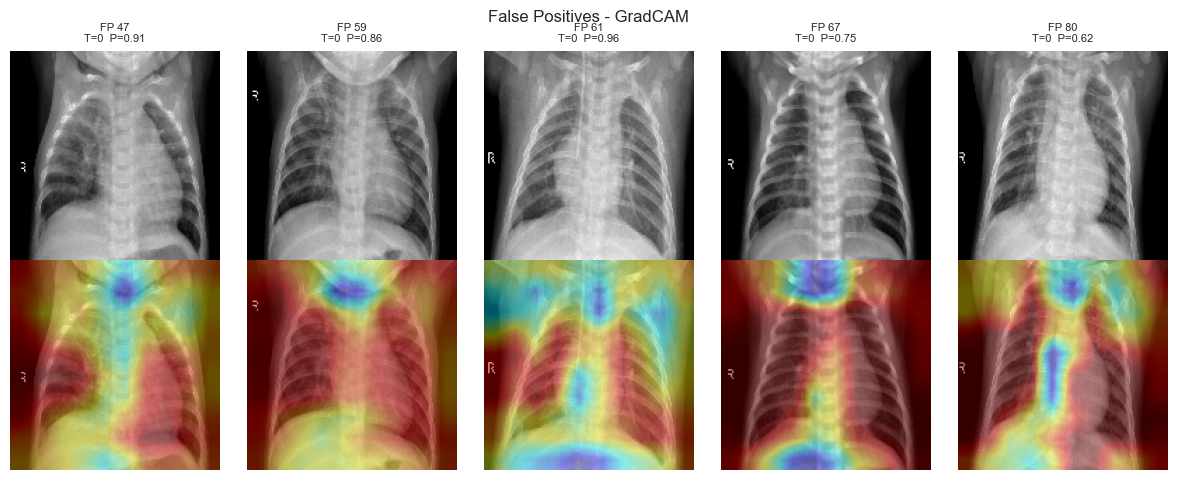

In [62]:
# ── False‑positive indices (P=1, T=0) ────────────────────────────────
false_pos  = np.where((pred_lbls == 1) & (y_test == 0))[0]

plt.figure(figsize=(12, 5))
for i, idx in enumerate(false_pos[:5]):
    gray  = x_test[idx].reshape(150, 150)
    batch = np.expand_dims(gray, axis=(0, -1))     # (1,150,150,1)
    cam   = make_gradcam_heatmap(batch, grad_model)  # je eerdere grad_model
    over  = overlay_heatmap(gray, cam)

    # rij 1: origineel
    plt.subplot(2, 5, i + 1)
    plt.imshow(gray, cmap='gray')
    p = preds[idx][0]; t = y_test[idx]
    plt.title(f"FP {idx}\nT={t}  P={p:.2f}", fontsize=8)
    plt.axis('off')

    # rij 2: Grad‑CAM
    plt.subplot(2, 5, i + 6)
    plt.imshow(over)
    plt.axis('off')

plt.suptitle("False Positives - GradCAM", y=0.95)
plt.tight_layout()
plt.show()

In [63]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9444 - loss: 0.1816
Loss of the model is -  0.2748599350452423
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.9444 - loss: 0.1816
Accuracy of the model is -  91.50640964508057 %


# Analysis after Model Training

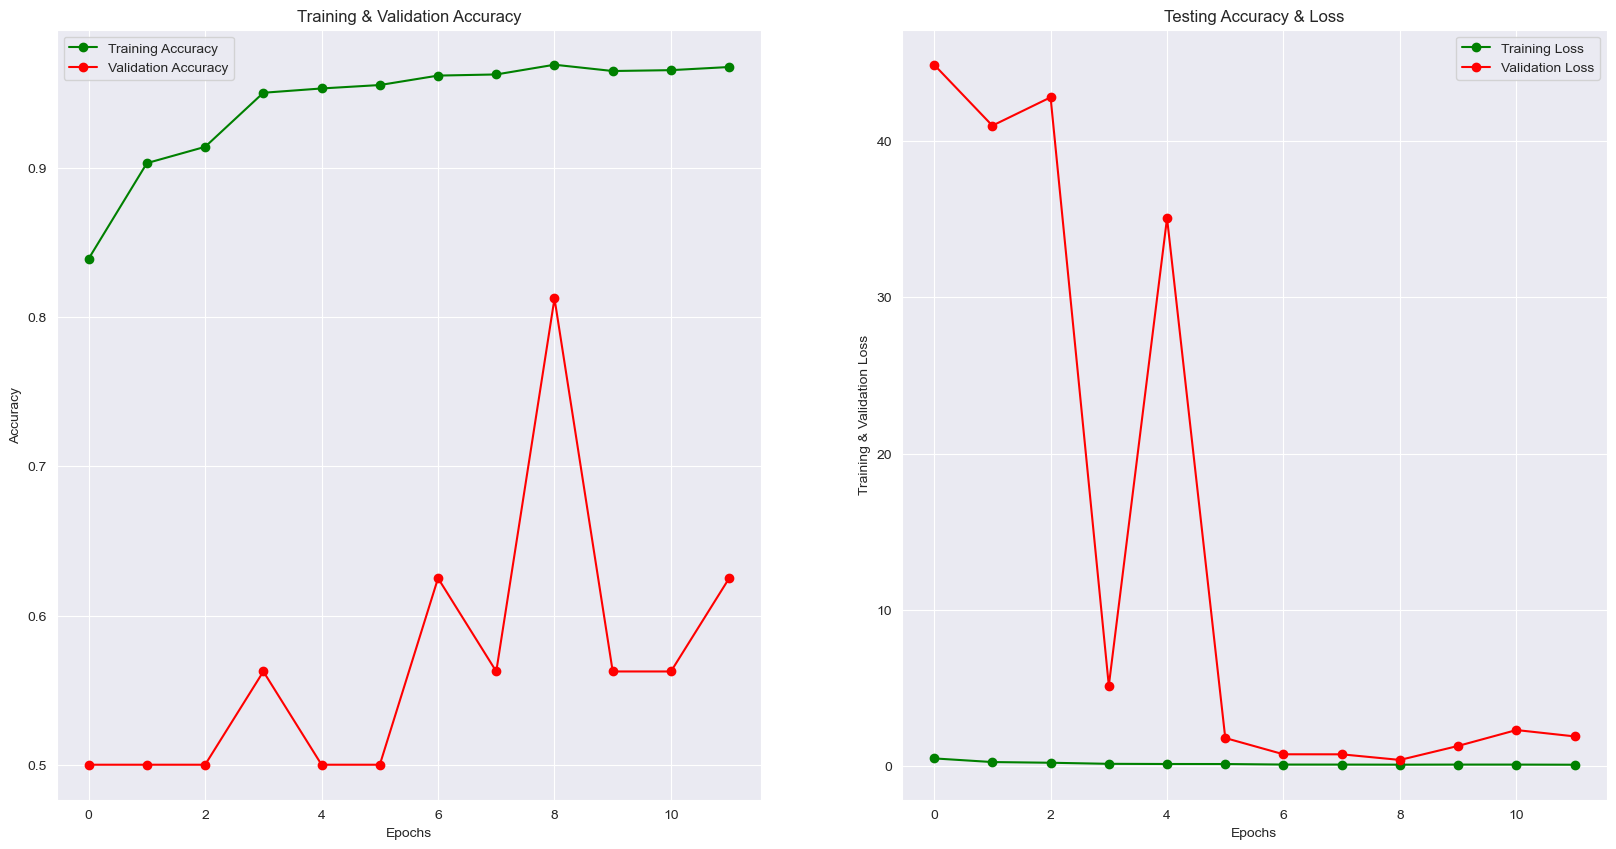

In [64]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [65]:
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype("int32")
predicted_classes[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 577ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [80]:
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [81]:
cm = confusion_matrix(y_test, predicted_classes)
cm


array([[361,  29],
       [ 29, 205]])

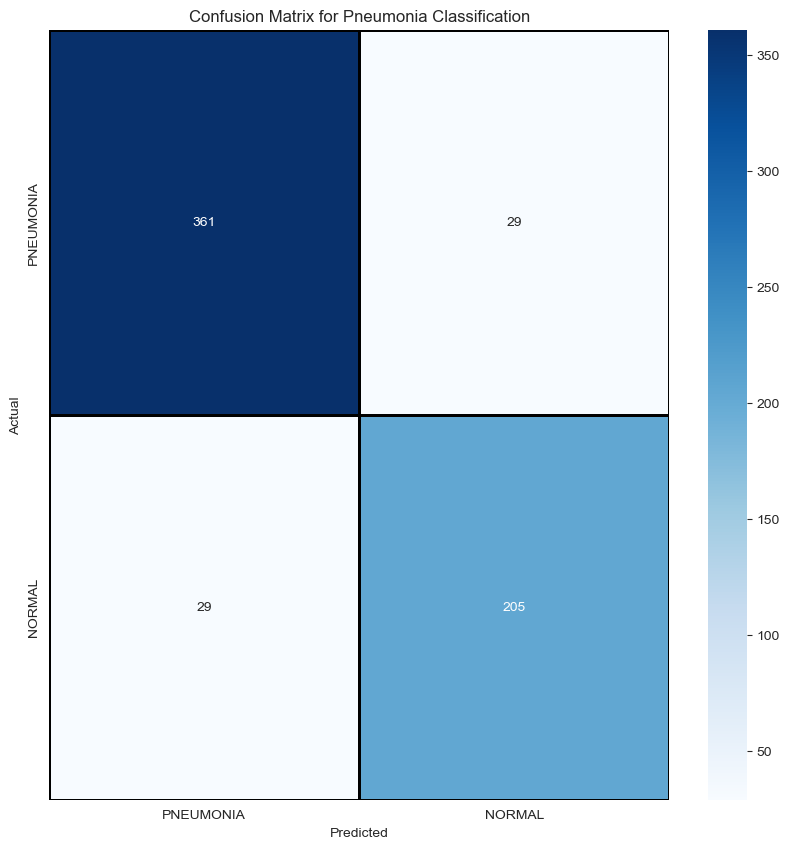

In [82]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1,
         annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Pneumonia Classification")
plt.show()


- There is a bug in the Seaborn library version being used (`0.12.0`), which causes only the top value to be filled in.  
- Unfortunately, the Seaborn library can't be updated since it conflicts with other dependencies.  
- So there is no quick fix for this — only creating the plot in a separate file using the up-to-date Seaborn library.  
- Run `pip install seaborn --upgrade` in a different environment to create a proper plot.


In [83]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

In [84]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

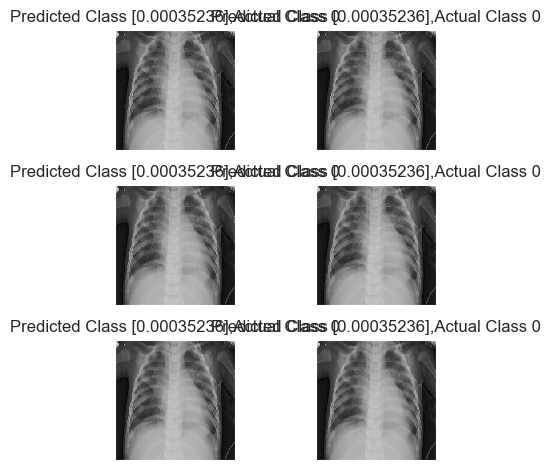

In [85]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Performance Evalutation


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       390
           1       0.00      0.00      0.00       234

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

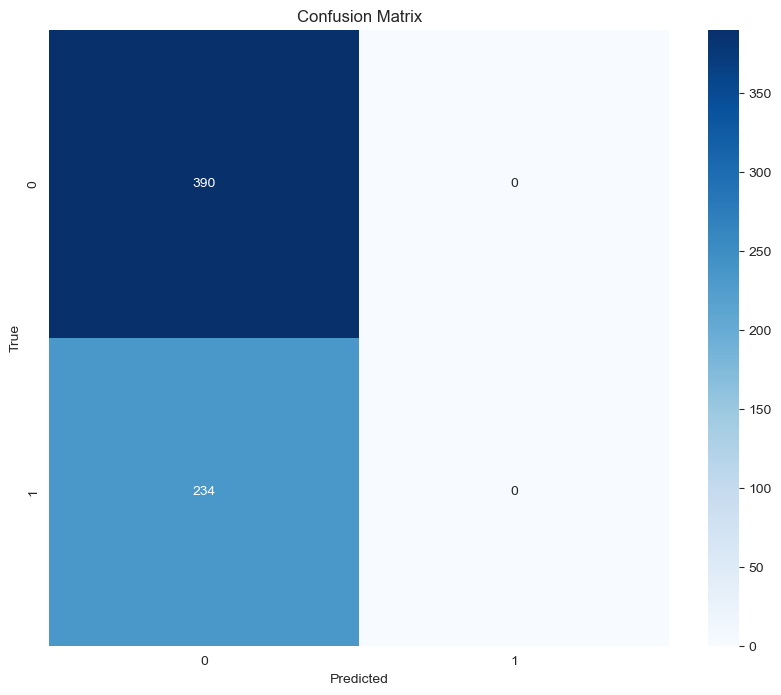

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Hyper Parameter Optimization

In [101]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

for lr in learning_rates:
    print(f"Training with learning rate = {lr}")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=12, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    print(f"Validation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f}")

Training with learning rate = 0.01


KeyboardInterrupt: 

In [102]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filters', values=[32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(150, 150, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filters', values=[64, 128, 256]),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice('dense_units', values=[64, 128, 256]),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='cnn_tuning'
)

tuner.search(x_train, y_train, epochs=12, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy}')

/Users/mac/anaconda3/envs/DS2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |conv_1_filters
3                 |3                 |conv_1_kernel
64                |64                |conv_2_filters
5                 |5                 |conv_2_kernel
64                |64                |dense_units
0.3               |0.3               |dropout_rate
0.0016651         |0.0016651         |learning_rate

Epoch 1/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 953ms/step - accuracy: 0.8680 - loss: 2.5652 - val_accuracy: 0.9962 - val_loss: 0.0137
Epoch 2/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 981ms/step - accuracy: 0.9298 - loss: 0.2047 - val_accuracy: 0.3889 - val_loss: 5.4537
Epoch 3/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9279 - loss: 0.1337 - val_accuracy: 0.0048 - val_loss: 23.1329
Epoch 4/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9271 - loss: 0.1116 - val_accuracy: 0.0000e+00 - val_loss: 1.7002
Epoch 5/12
  3/131 ━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
trials = list(tuner.oracle.trials.values())

for i, trial in enumerate(trials):
    print(f"\n🔹 Trial {i+1}")
    print(f"Score (val_accuracy): {trial.score:.4f}")
    for hp, val in trial.hyperparameters.values.items():
        print(f"{hp}: {val}")


🔹 Trial 1
Score (val_accuracy): 0.9013
conv_1_filters: 128
conv_1_kernel: 5
conv_2_filters: 256
conv_2_kernel: 3
dense_units: 256
dropout_rate: 0.30000000000000004
learning_rate: 0.0022080982419546116

🔹 Trial 2
Score (val_accuracy): 0.9080
conv_1_filters: 128
conv_1_kernel: 3
conv_2_filters: 256
conv_2_kernel: 3
dense_units: 256
dropout_rate: 0.4
learning_rate: 0.0001274939524304485

🔹 Trial 3
Score (val_accuracy): 0.0134
conv_1_filters: 64
conv_1_kernel: 5
conv_2_filters: 256
conv_2_kernel: 3
dense_units: 64
dropout_rate: 0.4
learning_rate: 0.0023385968908569412

🔹 Trial 4
Score (val_accuracy): 1.0000
conv_1_filters: 32
conv_1_kernel: 3
conv_2_filters: 64
conv_2_kernel: 3
dense_units: 128
dropout_rate: 0.30000000000000004
learning_rate: 0.0009080065553439061

🔹 Trial 5
Score (val_accuracy): 0.9215
conv_1_filters: 128
conv_1_kernel: 5
conv_2_filters: 64
conv_2_kernel: 5
dense_units: 64
dropout_rate: 0.1
learning_rate: 0.0028656743671223324


There must be an error in the 'tuner' cell as it incorrectly states that trial one has the highest accuracy value, we will continue with trial 4 as it acutally has the highest accuracy


In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides=1 , padding='same' , activation='relu' , input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides=2 , padding='same'))
model.add(Conv2D(64 , (3,3) , strides=1 , padding='same' , activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides=2 , padding='same'))
model.add(Conv2D(64 , (3,3) , strides=1 , padding='same' , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides=2 , padding='same'))
model.add(Conv2D(128 , (3,3) , strides=1 , padding='same' , activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides=2 , padding='same'))
model.add(Conv2D(256 , (3,3) , strides=1 , padding='same' , activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides=2 , padding='same'))
model.add(Flatten())
model.add(Dense(units=128 , activation='relu'))  # Best dense_units as per trial 4
model.add(Dropout(0.2))
model.add(Dense(units=1 , activation='sigmoid'))

# Best learning rate as per trial 4
optimizer = Adam(learning_rate=0.0009080065553439061)
model.compile(optimizer=optimizer , loss='binary_crossentropy' , metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_32 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_25 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_33 (Bat  (None, 75, 75, 64)     

In [89]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 133s 802ms/step - loss: 0.6023 - accuracy: 0.8391 - val_loss: 23.0247 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 133s 816ms/step - loss: 0.2667 - accuracy: 0.8986 - val_loss: 36.4973 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9195
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 130s 797ms/step - loss: 0.2231 - accuracy: 0.9195 - val_loss: 34.2272 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 130s 796ms/step - loss: 0.1563 - accuracy: 0.9477 - val_loss: 7.4953 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9467
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===============

In [90]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 165ms/step - loss: 0.6287 - accuracy: 0.8958
Loss of the model is -  0.6287482976913452
20/20 [==============================] - 3s 149ms/step - loss: 0.6287 - accuracy: 0.8958
Accuracy of the model is -  89.58333134651184 %


Secondary model: SVM

In [ ]:
X_flat = x_train.reshape(x_train.shape[0], -1)
X_flat = X_flat.astype('float32') / 255.0 

X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_flat, y_train, test_size=0.2, random_state=42
)

#Train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train_split)

#Evaluate the model
y_pred = svm_model.predict(X_val)
acc = accuracy_score(y_val_split, y_pred)

print(f"SVM Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_split, y_pred))

NameError: name 'SVC' is not defined

Performance Evaluation

20/20 [==============================] - 1s 49ms/step
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       390
           1       0.97      0.15      0.26       234

    accuracy                           0.68       624
   macro avg       0.82      0.57      0.53       624
weighted avg       0.78      0.68      0.59       624



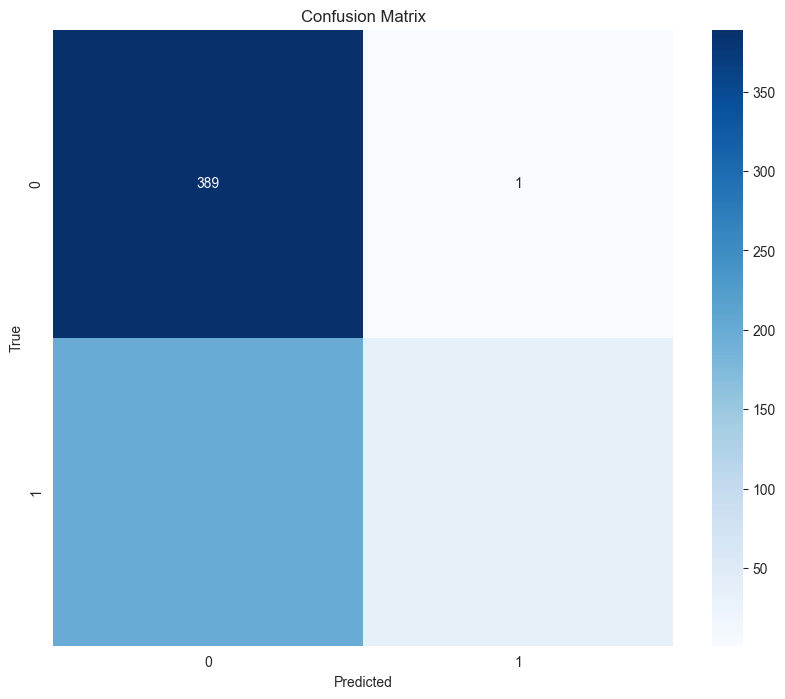

In [ ]:

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()